In [1]:
import math
import matplotlib.pyplot as plt
import random
import time
import copy
import heapq
import numpy as np

In [2]:
def get_some_randomness(l, r, elems):
    indexes=list(range(l, r))
    random.shuffle(indexes)
    return indexes[:elems]

def lipa_szafel(lista):
    lipa=lista[:]
    random.shuffle(lipa)
    return lipa


class Vertex:
    def __init__(self, v, preve=-1, nexte=-1):
        self.value=v
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def exchange(self, preve, nexte):
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def modern_exchange(self, preve, nexte, vertexes):
        past_preve=self.prev
        past_nexte=self.next
        
        self.exchange(preve, nexte)
        if self.present==False:
            vertexes[past_preve].next=past_nexte
            vertexes[past_nexte].prev=past_preve
        else:
            vertexes[preve].next=self.value
            vertexes[nexte].prev=self.value
            
    def check_consistency(self, vertexes):
        if not self.present:
            return
        if not vertexes[self.prev].next==self.value or not vertexes[self.next].prev==self.value:
            print(f"DUPA {self.value}")
    
    def __str__(self):
        return f'{self.value}: <{self.prev}, {self.next}>'

In [3]:
class Pathway:
    def _greedy_closest_neigh_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]<self.matrix[last][cur]:
            return True
        return False
    
    def _greedy_cycle_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]+self.matrix[start][compared]<self.matrix[last][cur]+self.matrix[start][cur]:
            return True
        return False

    def _get_maxes(self, v1, v2):
        if self._maxes[0]['place']==v1 or self._maxes[0]['place']==v2:
            if self._maxes[1]['place']==v1 or self._maxes[1]['place']==v2:
                return self._maxes[2]
            return self._maxes[1]
        return self._maxes[0]
    
    def _formulate_maxes(self):
        maxes=[]
        for x in self.vertexes:
            if x.present==False:
                continue
            maxes.append({'value':self.matrix[x.prev][x.value]+self.matrix[x.value][x.next]-self.matrix[x.prev][x.next], 'place':x.value})
        self._maxes=sorted(maxes, key=lambda x: x['value'], reverse=True)[:3]
        
    def _formulate_best(self):
        lst=[]
        for x in self.matrix:
            lst.append([y[0] for y in sorted(list(enumerate(x)), key=lambda x:x[1])[1:]])
        self.closer=lst
        
            
    def _double_regret(self, pathway, j, k=2, cnst=1):
        regrets=[]
        ln=len(pathway)
        for i in range(0, ln):
            v1=pathway[i]
            v2=pathway[(i+1)%ln]
            regrets.append((self.matrix[v1][j]+self.matrix[v2][j]-self.matrix[v1][v2], i))
        regrets=sorted(regrets, key=lambda x: x[0])

        sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
        for i in range(1, min(ln, k)):
            sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
        return sum_of_regrets, regrets[0][1]+1


    def _general_heuristic(self, start, comparer, regrets=False, k_reg=2, cnst=1):
        ln=len(self.matrix)//2
        allez=len(self.matrix)
        last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
        devoured[start]=1
        fortress_of_regrets=[0, -1]

        while len(path)<ln:
            for j in range(allez):
                if devoured[j]==1:
                    continue

                if regrets==True:
                    partial_regret=comparer(path, j, k_reg, cnst)
                    if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                        fortress_of_regrets=partial_regret
                        cur=j
                if regrets==False and (cur==-1 or comparer(last, path[0], cur, j)):
                    cur=j

            last, cur=cur, -1
            devoured[last]=1
            if regrets==False:
                path.append(last)
            else:
                path.insert(fortress_of_regrets[1], last)
            fortress_of_regrets=[0, -1]
        return path
    
    def _vertex_list_to_path(self):
        ln=self.halfway
        path=[]
        for i in range(len(self.matrix)):
            if self.vertexes[i].present==False:
                continue
            j=self.vertexes[i].next
            
            path=[i, j]
            while self.vertexes[j].next!=i:
                #print(f'ideal: {i}, preve: {self.vertexes[j].prev}, zis: {j}, nexte: {self.vertexes[j].next}')
                if self.vertexes[j].next!=j:
                    j=self.vertexes[j].next
                else:
                    j=self.vertexes[j].prev
                path.append(j)
        return path
    
    def _path_to_vertex_list(self):
        ln=self.halfway
        vertexes=[]
        for i in range(len(self.matrix)):
            d=Vertex(i)
            vertexes.append(d)
            
        for i, x in enumerate(self.pathway):
            d=Vertex(x, self.pathway[(i-1)%ln], self.pathway[(i+1)%ln])
            vertexes[x]=d
        return vertexes
    
    
    #Indexes, indexes everywhere; returns literal cost (negata - profit); only one present
    def _cost_swap_vertex(self, v1, v2):
        if self.vertexes[v2].present: #And its v1 present
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=self._get_maxes(v1, next1)['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        
        return max(eld-neue, -novel)
    
    #Swap v1, v2 with one outside
    def _swap_partial(self, v1, v2):
        if self.vertexes[v1].present==False: #v1 exists always
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        reason=self._get_maxes(v1, next1)
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=reason['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        if -novel > eld-neue:
            nel=next1
        else:
            nel=reason['place']
        
        self.vertexes[v2].modern_exchange(v1, next1, self.vertexes)
        self.vertexes[nel].modern_exchange(-1, -1, self.vertexes)
    
    def _swap_by_vertex(self, v1, v2):
        self._swap_partial(v1, v2)
    
    #Next edge after vertex swapped
    def _cost_swap_edges(self, v1, v2):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return -1
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        neue=self.matrix[v2][v1]+self.matrix[next1][next2]
        eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        return eld-neue
        
    def _swap_by_edge(self, v1, v2):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return None
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        j=next1
        while j!=next2:
            tmp=self.vertexes[j].prev
            self.vertexes[j].prev=self.vertexes[j].next
            self.vertexes[j].next=tmp
            j=self.vertexes[j].prev
        
        self.vertexes[next1].next=next2
        self.vertexes[next2].prev=next1
        
        self.vertexes[v1].exchange(self.vertexes[v1].prev, v2)
        self.vertexes[v2].exchange(v1, self.vertexes[v2].next)
        
    def _get_properties(self, i, j):
        if i==j or (not self.vertexes[i].present and not self.vertexes[j].present):
            return -1, -1
        if not self.vertexes[i].present or not self.vertexes[j].present:
            coste=self._cost_swap_vertex(i, j)
            return coste, self._swap_by_vertex
        else:
            coste=self._cost_swap_edges(i, j)
            return coste, self._swap_by_edge
            
        
    def greed(self, model_range=None):
        if model_range==None:
            model_range=list(range(0, self._full_len))
            
        while True:
            changed=False
            rn1=get_some_randomness(0, len(self.matrix), len(self.matrix))
            rn2=random.shuffle(model_range)
            
            for i in rn1:
                for j in model_range:
                    if j>=i:
                        continue
                    coste, fun=self._get_properties(i, j)
                    if coste<=0:
                        continue
                    changed=True
                    self.current_cost-=coste
                    fun(i, j)
                    self._formulate_maxes()
            if changed==False:
                return
            
    
    def execute_optimizer(self, name, params):
        _methods={
            'greed':self.greed,
            #'steep':self.steep,
            #'steep_candid':self.steep_candid,
            #'steep_heap':self.steep_heapov
        }
        _methods[name](*params)
        self.pathway=self._vertex_list_to_path()
    
    def cost(self):
        ln=self.halfway
        summa=0
        for i,x in enumerate(self.pathway):
            summa+=self.matrix[x][self.pathway[(i+1)%ln]]
        return summa
    
    
    def __init__(self, matrix, constr_method_and_args, start):
        _methods={
            'greedy closest neigh':self._greedy_closest_neigh_comparer,
            'greedy cycle':self._greedy_cycle_comparer,
            'k regret':self._double_regret,
            'random':'random'
        }
        self.halfway=len(matrix)//2
        self._full_len=len(matrix)
        
        self.matrix=matrix
        method=_methods[constr_method_and_args[0]]
        if  method=='random':
            self.pathway=get_some_randomness(1, len(matrix), self.halfway)
        else:
            self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
        self.current_cost=self.cost()
        self.vertexes=self._path_to_vertex_list()
        self.pathway=self._vertex_list_to_path()
        self._formulate_maxes()

In [4]:
def dissolve_absolve(path, percent=0.1):
    system=path._full_len
    cut_elems=math.ceil(path.halfway*percent)
    for i in range(cut_elems):
        a, b=np.random.randint(system), np.random.randint(system)
        h, fun=path._get_properties(a, b)
        if fun!=-1:
            fun(a, b)
            path._formulate_maxes()
    path.pathway=path._vertex_list_to_path()

def swapp(a, b):
    tmp=a
    a=b
    b=tmp
    return a, b            

def dissolve(path, ln=5, percent=0.2):
    system=path._full_len
    cut_elems=math.ceil(path.halfway*percent)
    to_cut=math.ceil(cut_elems/ln)
    removal=0
    for _ in range(to_cut):
        while True:
            a=np.random.randint(system)
            if path.vertexes[a].present==True:
                break
                
        for i in range(ln):
            nxt=path.vertexes[a].next
            path.vertexes[a].modern_exchange(-1, -1, path.vertexes)
            a=nxt
            removal+=1
            path._formulate_maxes()
    return path, removal


def move_adder(path, a, b):
    if path.vertexes[b].present==True: # a obecny
        a, b=swapp(a, b)
    nxt=path.vertexes[a].next
    return path.matrix[a][b]+path.matrix[b][nxt]-path.matrix[a][nxt]

def enchance(path, a, b):
    if path.vertexes[b].present==True:
        a, b=swapp(a, b)
    path.vertexes[b].modern_exchange(a, path.vertexes[a].next, path.vertexes)
    path._formulate_maxes()
    
def absolve(path, removed):
    system=path._full_len
    
    for i in range(removed):
        min_cost=Inf
        for j in range(system):
            for ij in range(j+1, system): #To zamienić przy roszadzie
                if path.vertexes[j].present^path.vertexes[i].present==True:
                    cost=move_adder(path, i, j)
                    if cost < min_cost:
                        min_cost, a, b=cost, i, j
        enchance(path, a, b)
    path.pathway=path._vertex_list_to_path()

def mls(iters, matrix):
        best_path=None
        costet=-1
        for i in range(iters):
            path_base=Pathway(matrix, ['random'], -1)
            path_base.execute_optimizer('greed', [])
            new_cost=path_base.cost()
            if best_path==None or costet>new_cost:
                best_path, costet=path_base, new_cost
        return best_path
    
def ils1(zeit, matrix, stable=False):
    path_base=Pathway(matrix, ['random'], -1)
    best_path=copy.deepcopy(path_base)
    
    costet=path_base.cost()
    t1=time.time()
    while time.time()-t1<zeit:
        path_base.execute_optimizer('greed', [])
        new_cost=path_base.cost()
        if costet>new_cost:
            best_path, costet=copy.deepcopy(path_base), new_cost
        elif stable==True:
            path_base=copy.deepcopy(best_path)
        dissolve_absolve(path_base)
    return best_path

def ils2(zeit, matrix, optimize=True, stable=False):
    path_base=Pathway(matrix, ['random'], -1)
    best_path=copy.deepcopy(path_base)
    costet=path_base.cost()
    
    t1=time.time()
    while time.time()-t1<zeit:
        if optimize==True:
            path_base.execute_optimizer('greed', [])        
        new_cost=path_base.cost()
            
        if costet > new_cost:
            best_path, costet=copy.deepcopy(path_base), new_cost
        elif stable==True:
            path_base=copy.deepcopy(best_path)
            
        path_base, removed = dissolve(path_base)
        absolve(path_base, removed)
    return best_path

In [5]:
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

def systematize(file_namez):
    properties={}
    for value in file_namez:
        x=file_namez[value]
        properties[x]={}
        properties[x]['res']=read_tsp(value)
        properties[x]['matrix']=calc_matrix(properties[x]['res'])
    return properties

    
file_namez={'../kroA200.tsp':'kroA200.tsp', '../kroB200.tsp':'kroB200.tsp'}
properties=systematize(file_namez)

In [ ]:
#reality=[('greed', ['greedy closest neigh']), ('cycle', ['greedy cycle']), 
#        ('2reg-1', ['k regret', True, 2, 0]), ('2reg-2', ['k regret', True, 2, 1]), ('random', ['random'])]

Inf=1000000000
def append_starter(dct, res, iters, name='res'):
    dct['min_'+name]=min(dct['min_'+name], res)
    dct['max_'+name]=max(dct['max_'+name], res)
    dct['avg_'+name]=res/iters+dct['avg_'+name]
    
def append_later(dct, res, path, zeit, iters):
    if res<dct['min_res']:
        dct['path']=path
    append_starter(dct, res, iters)
    append_starter(dct, zeit, iters, 'time')
    
def create_fields(dct, elem, namez):
    dct[elem]={}
    for x in namez:
        dct[elem]['min_'+x]=Inf
        dct[elem]['max_'+x]=0
        dct[elem]['avg_'+x]=0

post_reality=[('random', ['random'])]
reality=[('mls', [mls]), ('ils1', [ils1]), ('ils1_stable', [ils1, True]),
         ('ils2', [ils2, True]), ('ils2a', [ils2, False]), ('ils2_stable', [ils2, True, True])]
#reality=[('ils2a', [ils2, False, True])]

system={}

iters=10
modern_iters=100
for y in reality:
    for falka in range(iters):
        print(f'iteracja nr {falka}')
        for x in properties:
            matrix=properties[x]['matrix']
            alpha=('random', ['random'])
            
            if (x, alpha[0], y[0]) not in system:
                create_fields(system, (x, alpha[0], y[0]), ['res', 'time'])

            t1=time.time()
            if y[0]=='mls':
                some_path=y[1][0](modern_iters, matrix) #Tu optymalizacja, tu roche-da
            else:
                zeit=system[(x, 'random', 'mls')]['avg_time']
                some_path=y[1][0](zeit, matrix, *y[1][1:])
            t2=time.time()-t1
            print(t2)

            append_later(system[(x, alpha[0], y[0])], some_path.cost(), some_path.pathway, t2, iters)

In [ ]:
def print_map(res, path, ax):
    ax.plot([1,2], [3,4])
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')
    ax.scatter([x[1] for x in res], [x[2] for x in res], color='red')

mapp={'kroA200.tsp':0, 'kroB200.tsp':1, 
      'mls':0, 'ils1':1, 'ils1_stable':2, 'ils2':3, 'ils2a':4, 'ils2_stable':5,
     'random':0, '2reg-2':1}

naming={'mls':'wielostartowy, ls', 'ils1':'iterowany, ls, random',
        'ils1_stable':'stabilny, iterowany, ls, random',
        'ils2':'iterowany, ls, heura', 'ils2a':'iterowany, bez ls',
        'ils2_stable':'stabilny, iterowany, ls, heura',
       'random':'losowy', '2reg-2':'2-żal 2.0'}

all_solutions=len(reality)

for y in post_reality:
    typic=18
    plots=len(reality)
    fig, ax=plt.subplots(plots, 2, figsize=(2*typic, plots*typic))
    if plots==1:
        ax=[ax]
        
    for x in system:
        if x[1]!=y[0]:
            continue
        col=mapp[x[0]]
        row=mapp[x[2]]-3
        if row<0:
            continue
        print_map(properties[x[0]]['res'], system[x]['path'], ax[row][col])
        ax[row][col].set_title(f'Algorytm {naming[x[2]]} na instancji {x[0]}', size=18)
    plt.savefig(f"heury2_{y[0]}.svg", bbox_inches="tight")

In [ ]:
neo_naming={
    'mls':('multistart', '-'), 'ils1':('iterowany', 'random'), 
    'ils1_stable':('stabilny, iterowany', 'random'), 'ils2_stable':('stabilny, iterowany', 'heura'),
    'ils2a':('iterowany, nie-ls', 'heura'), 'ils2':('iterowany', 'heura')
}

for x in system:
    print(f'{x[0]} & {neo_naming[x[2]][0]} & {neo_naming[x[2]][1]}', end='')
    for y in system[x]:
        if y!='path':
            print(f' & {system[x][y]:.2f}', end='')
    print('\\\\ \\hline')

In [ ]:
print(system_starter)

In [21]:
iterato=1000
neo_post_properties={}
for x in properties:
    neo_post_properties[x]={}
    neo_post_properties[x]['indexo_culto']=-1
    neo_post_properties[x]['besto_costo']=10000000000
    neo_post_properties[x]['all_pathways']=[]
    
    for _ in range(iterato):
        path=Pathway(properties[x]['matrix'], ['random'], -1)
        path.execute_optimizer('greed', [])
        neo_post_properties[x]['all_pathways'].append((path.pathway, path.cost()))
        if path.cost() < neo_post_properties[x]['besto_costo']:
            neo_post_properties[x]['indexo_culto']=_
            neo_post_properties[x]['besto_costo']=path.cost()

In [22]:
###Zadanie 1
def setize_v(pathway):
    return set(pathway)

def sorty(a, b):
    if a<b:
        return a, b
    else:
        return b, a

def setize_e(pathway):
    return set([sorty(pathway[i], pathway[(i+1)%len(pathway)]) for i,x in enumerate(pathway)])

def setify(pathway):
    set_v=setize_v(pathway)
    set_e=setize_e(pathway)
    return set_v, set_e

def compare_sets(seta, setb):
    return len(seta&setb)

def avg(a):
    return sum(a)/len(a)

systemz=[('edge', 'best'), ('edge', 'avg'), ('vertex', 'best'), ('vertex', 'avg')]
post_mapp={'kroA200.tsp':0, 'kroB200.tsp':1,
          **{x:i for i,x in enumerate(systemz)}}

to_show={}
for x in properties:
    best_way=neo_post_properties[x]['all_pathways'][neo_post_properties[x]['indexo_culto']][0]
    to_show[x]={}
    for y in systemz:
        to_show[x][y]={}
        to_show[x][y]['x']=[h[1] for h in neo_post_properties[x]['all_pathways']]
        fun=setize_e if y[0]=='edge' else setize_v
        if y[1]=='best':
            to_show[x][y]['y']=[compare_sets(fun(h[0]), fun(best_way)) for h in neo_post_properties[x]['all_pathways']]
        else:
            to_show[x][y]['y']=[avg([compare_sets(fun(h[0]), fun(g[0])) for g in neo_post_properties[x]['all_pathways'] if g!=h]) for h in neo_post_properties[x]['all_pathways']]

In [39]:
further_to_elaborate={}

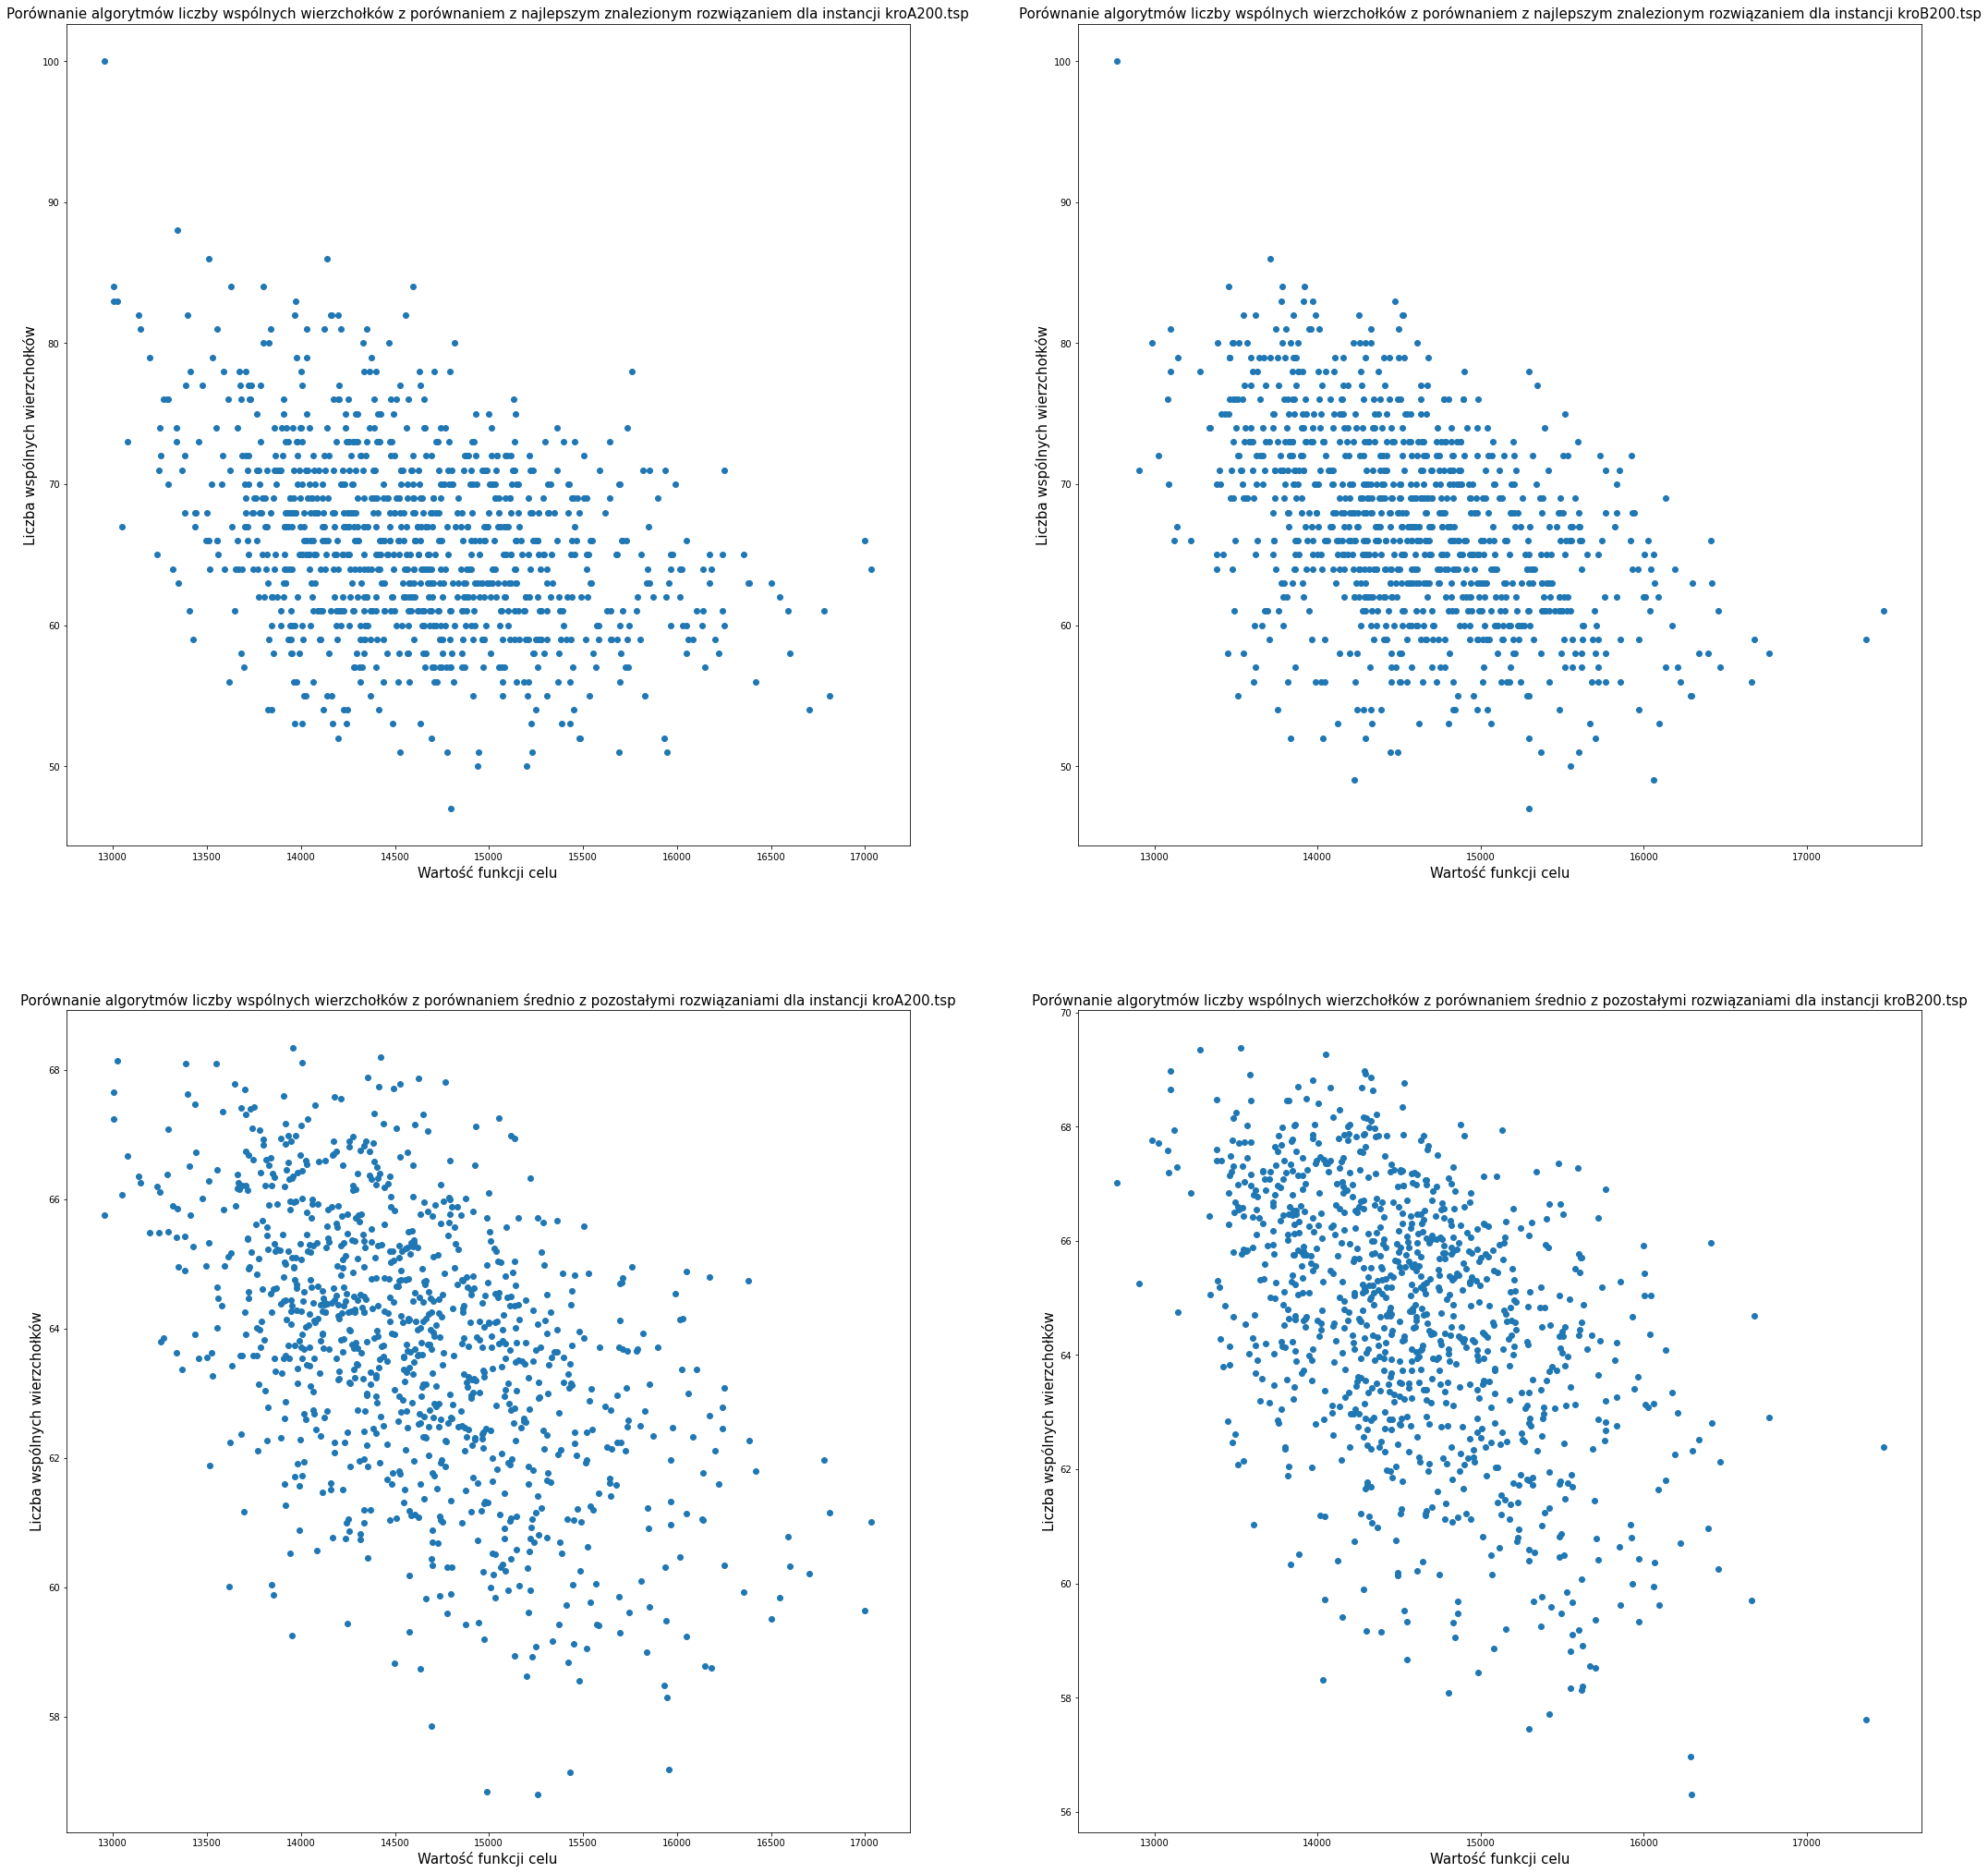

In [41]:
n=len(properties)
m=2

plot_mapp={
    'edge': 'liczby wspólnych krawędzi',
    'vertex': 'liczby wspólnych wierzchołków',
    'best': 'z najlepszym znalezionym rozwiązaniem',
    'avg': 'średnio z pozostałymi rozwiązaniami',
}

to_use=1
fig, ax=plt.subplots(m, n, figsize=(18*n, 18*m))
for x in properties:
    for y in systemz:
        if post_mapp[y]<=1:
            continue
        place=post_mapp[y]-to_use*2
        
        ax[place][post_mapp[x]].scatter(to_show[x][y]['x'], to_show[x][y]['y'])
        ax[place][post_mapp[x]].set_title(f'Porównanie algorytmów {plot_mapp[y[0]]} z porównaniem {plot_mapp[y[1]]} dla instancji {x}', size=15)
        ax[place][post_mapp[x]].set_xlabel(f'Wartość funkcji celu', size=15)
        ax[place][post_mapp[x]].set_ylabel(f'Liczba wspólnych {"krawędzi" if y[0]=="edge" else "wierzchołków"}', size=15)
        correlation_coef=np.corrcoef(x=to_show[x][y]['x'], y=to_show[x][y]['y'])[0][1]
        further_to_elaborate[(x, y[0], y[1])]=correlation_coef
fig.savefig(f'por{to_use+1}.svg', bbox_inches="tight")

In [45]:
neo_naming={
    'edge':'krawędzie', 'vertex':'wierzchołki',
    'best':'z najlepszym', 'avg':'średnio'
}

for x in further_to_elaborate:
    print(f'{x[0]} & {neo_naming[x[1]]} & {neo_naming[x[2]]} & {further_to_elaborate[x]:.2f} \\\\ \\hline')

kroA200.tsp & krawędzie & z najlepszym & -0.40 \\ \hline
kroA200.tsp & krawędzie & średnio & -0.56 \\ \hline
kroB200.tsp & krawędzie & z najlepszym & -0.54 \\ \hline
kroB200.tsp & krawędzie & średnio & -0.61 \\ \hline
kroA200.tsp & wierzchołki & z najlepszym & -0.34 \\ \hline
kroA200.tsp & wierzchołki & średnio & -0.50 \\ \hline
kroB200.tsp & wierzchołki & z najlepszym & -0.45 \\ \hline
kroB200.tsp & wierzchołki & średnio & -0.47 \\ \hline


In [ ]:
############# Olden
def post_greed(self, model_ranges=None):
    model_range=model_ranges
    if model_ranges==None:
        model_range=[list(range(0, self._full_len)) for _ in range(0, self._full_len)]
    iterat=0

    while True:
        changed=False
        rn1=get_some_randomness(0, len(self.matrix), len(self.matrix))

        for i in rn1:
            for j in model_range[i]:
                x, y=i, j
                if j==i:
                    continue
                coste, fun=self._get_properties(x, y)
                if coste<=0:
                    if self.vertexes[i].present==True and self.vertexes[j].present==True:
                        x, y=self.vertexes[i].prev, self.vertexes[j].prev
                    elif self.vertexes[i].present==True:
                        x, y=self.vertexes[i].prev, j
                    elif self.vertexes[j].present==True:
                        x, y=i, self.vertexes[j].prev
                    else:
                        x, y=-1, -1
                    coste, fun=self._get_properties(x, y)
                    if coste<=0:
                        continue
                changed=True
                self.current_cost-=coste
                fun(x, y)
                self._formulate_maxes()
        if changed==False:
            return
        iterat+=1
    
    
def greed(self):
        
    pw=16
    kk=pw
    n=self._full_len
    while pw==kk:
    #while pw//2<self._full_len:
        self.post_greed([self.closer[h][:min(pw, n-1)] for h in range(0, n)])
        pw*=2
            
def __init__(self, matrix, constr_method_and_args, start):
    _methods={
        'greedy closest neigh':self._greedy_closest_neigh_comparer,
        'greedy cycle':self._greedy_cycle_comparer,
        'k regret':self._double_regret,
        'random':'random'
    }
    self.halfway=len(matrix)//2
    self._full_len=len(matrix)

    self.matrix=matrix
    method=_methods[constr_method_and_args[0]]
    if  method=='random':
        self.pathway=get_some_randomness(1, len(matrix), self.halfway)
    else:
        self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
    self.current_cost=self.cost()
    self.vertexes=self._path_to_vertex_list()
    self.pathway=self._vertex_list_to_path()
    self._formulate_maxes()
    self._formulate_best()